In the last project, we made our first submission to Kaggle, getting an accuracy score of 75.6%. While this is a good start, there is definitely room for improvement. There are two main areas we can focus on to boost the accuracy of our predictions:

* Improving the features we train our model on
* Improving the model itself

In this project, we're going to focus working with the features used in our model.

Feature selection is important because it helps to exclude features which are not good predictors, or features that are closely related to each other. Both of these will cause our model to be less accurate, particularly on previously unseen data.

The diagram below illustrates this. The red dots represent the data we are trying to predict, and each of the blue lines represents a different model.

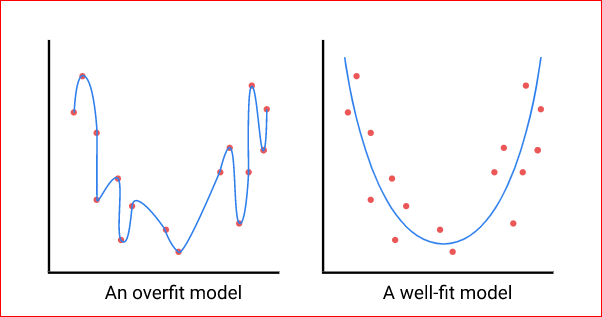

The model on the left is **overfitting**, which means the model represents the training data too closely, and is unlikely to predict well on unseen data, like the holdout data for our Kaggle competition.

The model on the right is **well-fit**. It captures the underlying pattern in the data without the detailed noise found just in the training set. A well fit model is likely to make accurate predictions on previously unseen data. The key to creating a well-fit model is to select the right balance of features, and to create new features to train our model.

In the last project, we trained our model using data about the age, sex and class of the passengers on the Titanic. Let's start by using the functions we created in that project to add the columns we had at the end of the first project.

Remember that any modifications we make to our training data (train.csv) we also have to make to our holdout data (test.csv).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [10]:
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_name = ["Missing", "Infant", "Child", "Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],bins= cut_points, labels=label_name )
    return df

In [11]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix= column_name)
    df = pd.concat([df, dummies], axis = 1)
    return df

In [12]:
train = process_age(train)
holdout = process_age(holdout)

In [13]:
for column in ["Age_categories","Pclass","Sex"]:
    train = create_dummies(train, column)
    holdout = create_dummies(holdout, column)

In [14]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


In [15]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.

Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to rescale the data.

Rescaling simply stretches or shrinks the data as needed to be on the same scale, in our case between 0 and 1.

Within scikit-learn, the [preprocessing.minmax_scale() function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html) allows us to quickly and easily rescale our data:

In [16]:
from sklearn.preprocessing import minmax_scale

# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.

holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

columns = ["SibSp","Parch","Fare"]
for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col+"_scaled"] = minmax_scale(holdout[col])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

The scikit-learn [LogisticRegression class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has an attribute in which coefficients are stored after the model is fit, LogisticRegression.coef_. We first need to train our model, after which we can access this attribute.

The coef() method returns a NumPy array of coefficients, in the same order as the features that were used to fit the model.

In [18]:
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])
cofficient = lr.coef_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


To make these easier to interpret, we can convert the coefficients to a pandas series, adding the column names as the index:

In [31]:
feature_importance = pd.Series(cofficient[0], index = columns)
feature_importance

Age_categories_Missing       -0.347236
Age_categories_Infant         1.860606
Age_categories_Child          0.344932
Age_categories_Teenager      -0.182734
Age_categories_Young Adult   -0.011089
Age_categories_Adult         -0.526202
Age_categories_Senior        -0.900500
Pclass_1                      1.045156
Pclass_2                      0.137295
Pclass_3                     -0.944674
Sex_female                    1.456109
Sex_male                     -1.218332
Embarked_C                    0.250103
Embarked_Q                    0.243743
Embarked_S                   -0.256069
SibSp_scaled                 -1.747757
Parch_scaled                 -0.776502
Fare_scaled                   0.543085
dtype: float64

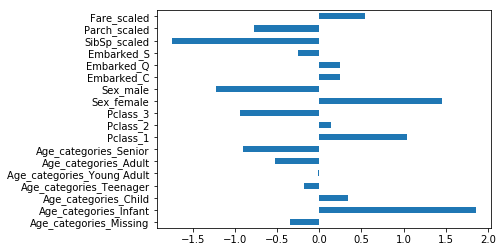

In [32]:
feature_importance.plot.barh()

The plot we generated showed a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value. If we think about it, this makes sense. A feature that indicates strongly whether a passenger died is just as useful as a feature that indicates strongly that a passenger survived, given they are mutually exclusive outcomes.

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

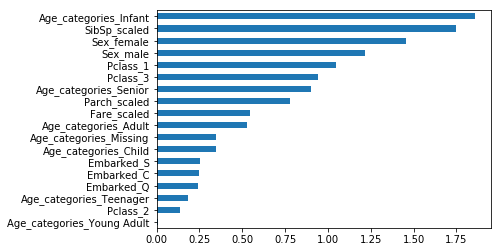

In [35]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()

We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [48]:
from sklearn.model_selection import cross_val_score

columns = ordered_feature_importance.sort_values(ascending = False).iloc[:8].index.tolist()
columns

['Age_categories_Infant',
 'SibSp_scaled',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_3',
 'Age_categories_Senior',
 'Parch_scaled']

In [49]:
lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train["Survived"], cv = 10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

The cross validation score of 81.48% is marginally higher than the cross validation score for the model we created in the previous project, which had a score of 80.2%.

Hopefully, this improvement will translate to previously unseen data. Let's train a model using the columns from the previous step, make some predictions on the holdout data and submit it to Kaggle for scoring.

In [50]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_1.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


When we submit it to Kaggle, we'll see that the score is 77.0%, which at the time of writing equates to jumping about 1,500 places up the leaderboard (this will vary as the leaderboard is always changing). It's only a small improvement, but we're moving in the right direction.

A lot of the gains in accuracy in machine learning come from **Feature Engineering**. Feature engineering is the practice of creating new features from existing data.

One common way to engineer a feature is using a technique called **binning**. Binning is when we take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable.

This can be useful when there are patterns in the data that are non-linear and we're using a linear model (like logistic regression). We actually used binning when we dealt with the Age column

In [51]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

Another way to engineer features is by extracting data from text columns. 

The Name and Cabin columns arn't useful by themselves, but what if there is some data there we could extract? 

Let's take a look at a random sample of rows from those two columns:

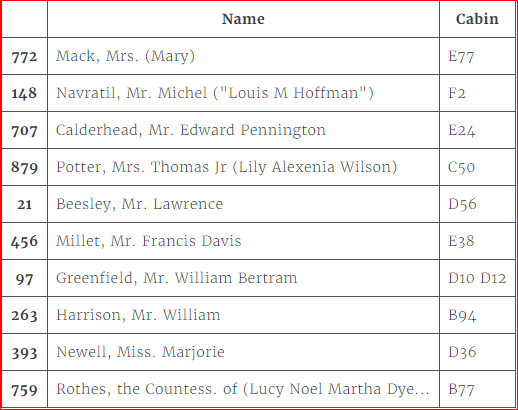

While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us.

Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types:

* Mr
* Mrs
* Master
* Miss
* Officer
* Royalty

In [68]:
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
extracted_titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [62]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

In [69]:
train["Title"] = extracted_titles.map(titles)

In [70]:
extracted_titles = holdout["Name"].str.extract("([A-Za-z]+)\.", expand = False)
holdout["Title"] = extracted_titles.map(titles)

In [72]:
train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"].value_counts(dropna = False)

NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Cabin_type, dtype: int64

In [73]:
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

In [75]:
for column in ["Title","Cabin_type"]:
    train = create_dummies(train, column)
    holdout = create_dummies(holdout, column)

We now have 34 possible feature columns we can use to train our model. One thing to be aware of as we start to add more features is a concept called **collinearity**. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that our model will overfit - we may get great results on our test data set, but then the model performs worse on unseen data (like the holdout set).

One easy way to understand collinearity is with a simple binary variable like the Sex column in our dataset. Every passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'.

As a result, when we created our two dummy columns from the categorical Sex column, we've actually created two columns with identical data in them. This will happen whenever we create dummy columns, and is called the [dummy variable trap](https://www.algosome.com/articles/dummy-variable-trap-regression.html). The easy solution is to choose one column to drop any time you make dummy columns.

Collinearity can happen in other places, too. A common way to spot collinearity is to plot correlations between each pair of variables in a heatmap.

The darker squares, whether the darker red or darker blue, indicate pairs of columns that have higher correlation and may lead to collinearity. The easiest way to produce this plot is using the DataFrame.corr() method to produce a correlation matrix, and then use the Seaborn library's seaborn.heatmap() function to plot the values:

In [93]:
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    

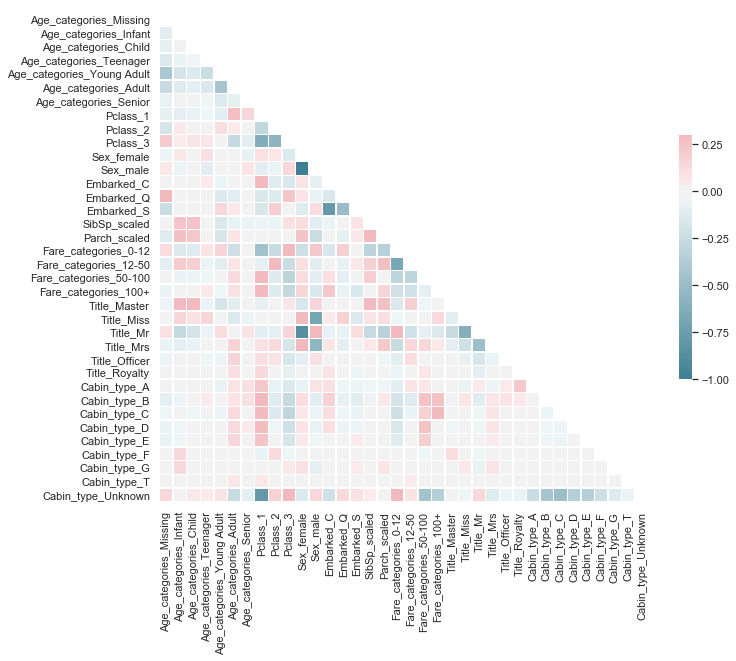

In [94]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

* Pclass_2
* Age_categories_Teenager
* Fare_categories_12-50
* Title_Master
* Cabin_type_A

In an earlier step, we manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the [feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) class which performs **recursive feature elimination** with cross-validation

The RFECV class starts by training a model using all of our features and scores it using cross validation. It then uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end, the class looks at all the scores, and selects the set of features which scored highest.

Like the LogisticRegression class, RFECV must first be instantiated and then fit. The first parameter when creating the RFECV object must be an estimator, and we need to use the cv parameter to specific the number of folds for cross-validation.

Once the RFECV object has been fit, we can use the RFECV.support_ attribute to access a boolean mask of True and False values which we can use to generate a list of optimized columns:

In [98]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr, cv = 10)
selector.fit(all_X, all_y)
optimized_columns = all_X.columns[selector.support_]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [99]:
print(optimized_columns)

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')


Let's train a model using cross validation using these columns and check the score.

In [101]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv = 10)
accuracy = scores.mean()
accuracy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.8226549199863807

This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model. Let's train these columns on the holdout set, save a submission file and see what score we get from Kaggle.

In [102]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission_2.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score this submission gets is 78.0%, which is equivalent to a jump of roughly 1,000 spots (again, this will vary as submission are constantly being made to the leaderboard).

By preparing, engineering and selecting features, we have increased our accuracy by 2.4%. When working in Kaggle competitions, we should spend a lot of time experimenting with features, particularly feature engineering.

Here are some ideas that we can use to work with features for this competition:

* Use SibSp and Parch to explore total relatives onboard.
* Create combinations of multiple columns, for instance Pclass + Sex.
* See if we can extract useful data out of the Ticket column.
* Try different combinations of features to see if we can identify features that overfit less than others.